In [1]:
import geopandas as gpd
import pandas as pd
import datetime
from dateutil import tz
import stride
import folium

In [2]:
pd.options.display.max_columns = 1000
pd.options.display.max_colwidth = 1000

In [3]:
def localize_dates(data, dt_columns = []):
    data = data.copy()
    
    for c in dt_columns:
        data[c] = pd.to_datetime(data[c]).dt.tz_convert('Israel')
    
    return data

In [4]:
pd.DataFrame(stride.get('/gtfs_routes/list', {'route_short_name':490,
                                                            'agency_name': 'אגד',
                                                            'route_long_name_contains': 'ירושלים',
                                              'date_from': '2022-12-12',
                                              'date_to':  '2022-12-12'}))

,id,date,line_ref,operator_ref,route_short_name,route_long_name,route_mkt,route_direction,route_alternative,agency_name,route_type
0,1868868,2022-12-12,34316,3,490,ת.רכבת תל אביב - סבידור/רציפים B-תל אביב יפו<->ברעם/האומן-ירושלים-1#,13490,1,#,אגד,3
1,1868869,2022-12-12,34317,3,490,ברעם/האומן-ירושלים<->ת. רכבת תל אביב - סבידור/הורדה-תל אביב יפו-3#,13490,3,#,אגד,3


In [5]:
siri_locations_490_before = pd.DataFrame(stride.get('/siri_vehicle_locations/list', {
    'siri_routes__line_ref': '34317',
    'limit': -1,
    'siri_rides__schedualed_start_time_from': datetime.datetime(2022,12, 4, tzinfo=tz.gettz('Israel')),
    'siri_rides__schedualed_start_time_to': datetime.datetime(2022,12, 8, tzinfo=tz.gettz('Israel'))+datetime.timedelta(days=1),
    'order_by': 'recorded_at_time desc',
    'lon__greater_or_equal': 35.11072,
    'lon__lower_or_equal': 35.19670,
    'lat__greater_or_equal': 31.76620,
    'lat__lower_or_equal': 31.81334
}))

siri_locations_490_before.shape

(1721, 35)

In [6]:
dt_columns = ['recorded_at_time','siri_ride__scheduled_start_time']

siri_locations_490_before = localize_dates(siri_locations_490_before, dt_columns)

In [7]:
siri_locations_490_before.columns

Index(['id', 'siri_snapshot_id', 'siri_ride_stop_id', 'recorded_at_time',
       'lon', 'lat', 'bearing', 'velocity', 'distance_from_journey_start',
       'distance_from_siri_ride_stop_meters', 'siri_snapshot__id',
       'siri_snapshot__snapshot_id', 'siri_snapshot__etl_status',
       'siri_snapshot__etl_start_time', 'siri_snapshot__etl_end_time',
       'siri_snapshot__error',
       'siri_snapshot__num_successful_parse_vehicle_locations',
       'siri_snapshot__num_failed_parse_vehicle_locations',
       'siri_snapshot__num_added_siri_rides',
       'siri_snapshot__num_added_siri_ride_stops',
       'siri_snapshot__num_added_siri_routes',
       'siri_snapshot__num_added_siri_stops', 'siri_snapshot__last_heartbeat',
       'siri_snapshot__created_by', 'siri_ride__id', 'siri_ride__journey_ref',
       'siri_ride__scheduled_start_time', 'siri_ride__vehicle_ref',
       'siri_ride__first_vehicle_location_id',
       'siri_ride__last_vehicle_location_id', 'siri_ride__duration_minutes'

In [8]:
locations_490_before = siri_locations_490_before[['recorded_at_time','siri_ride__scheduled_start_time',
                                   'lon','lat','siri_ride__vehicle_ref', 'siri_ride__id', 'distance_from_journey_start', 'velocity']]

In [9]:
ride_gpd = gpd.GeoDataFrame(locations_490_before, geometry=gpd.points_from_xy(locations_490_before.lon, locations_490_before.lat))

C:\Users\asher\Miniconda3\envs\siri\lib\site-packages\geopandas\array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)


## Visualizing the data to see if nothing looks wrong

In [ ]:
m = folium.Map(location=[31.78,35.18], zoom_start=15, tiles='OpenStreetMap')
glist = [[point.xy[1][0], point.xy[0][0]] for point in ride_gpd.geometry]
for i, coo in enumerate(glist):
    m.add_child(
        folium.Marker(
            location=coo,
            popup=ride_gpd.recorded_at_time[i],
            icon = folium.Icon()
        )
    )
m

#### Now let's look at the last siri call of each ride

In [15]:
last_recs = ride_gpd.groupby('siri_ride__id').first()

m = folium.Map(location=[31.80,35.12], zoom_start=15, tiles='OpenStreetMap')
glist = [[point.xy[1][0], point.xy[0][0]] for point in last_recs.geometry]
for i, coo in zip(last_recs.index, glist):
    m.add_child(
        folium.Marker(
            location=coo,
            popup=i
        )
    )

m

##### All the data points are after "Hemed" bus stop, except for ride #25405175

In [32]:
first_recs = ride_gpd.groupby('siri_ride__id').last()

m = folium.Map(location=[31.77,35.19], zoom_start=15, tiles='OpenStreetMap')
glist = [[point.xy[1][0], point.xy[0][0]] for point in first_recs.geometry]
for i, coo in zip(first_recs.index, glist):
    m.add_child(
        folium.Marker(
            location=coo,
            popup=i
        )
    )

m

In [33]:
first_recs

,recorded_at_time,siri_ride__scheduled_start_time,lon,lat,siri_ride__vehicle_ref,distance_from_journey_start,velocity,geometry
siri_ride__id,,,,,,,,
25360681,2022-12-04 06:17:08+02:00,2022-12-04 06:00:00+02:00,35.192955,31.767380,7695369,8607,29,POINT (35.19295 31.76738)
25363851,2022-12-04 06:55:07+02:00,2022-12-04 06:30:00+02:00,35.193962,31.767111,7821969,8607,43,POINT (35.19396 31.76711)
25367526,2022-12-04 07:28:38+02:00,2022-12-04 07:00:00+02:00,35.194878,31.766853,7692169,8366,0,POINT (35.19488 31.76685)
25370113,2022-12-04 07:56:52+02:00,2022-12-04 07:20:00+02:00,35.196102,31.766460,7625369,8251,32,POINT (35.19610 31.76646)
25372443,2022-12-04 08:10:10+02:00,2022-12-04 07:40:00+02:00,35.196644,31.766333,7636669,8171,36,POINT (35.19664 31.76633)
...,...,...,...,...,...,...,...,...
25858238,2022-12-08 18:19:11+02:00,2022-12-08 18:00:00+02:00,35.195126,31.766855,23329702,8346,29,POINT (35.19513 31.76685)
25861436,2022-12-08 18:54:05+02:00,2022-12-08 18:30:00+02:00,35.195099,31.766823,23318702,8359,36,POINT (35.19510 31.76682)
25864524,2022-12-08 19:22:04+02:00,2022-12-08 19:00:00+02:00,35.194969,31.766806,7693569,8336,36,POINT (35.19497 31.76681)


In [35]:
last_recs.recorded_at_time

siri_ride__id
25360681   2022-12-04 06:25:22+02:00
25363851   2022-12-04 07:07:38+02:00
25367526   2022-12-04 07:39:40+02:00
25370113   2022-12-04 08:08:07+02:00
25372443   2022-12-04 08:23:09+02:00
                      ...           
25858238   2022-12-08 18:28:11+02:00
25861436   2022-12-08 19:04:42+02:00
25864524   2022-12-08 19:33:56+02:00
25867151   2022-12-08 19:57:54+02:00
25869783   2022-12-08 20:34:17+02:00
Name: recorded_at_time, Length: 154, dtype: datetime64[ns, Israel]

In [41]:
first_last = first_recs.join(last_recs, rsuffix='_last')

In [43]:
first_last.columns

Index(['recorded_at_time', 'siri_ride__scheduled_start_time', 'lon', 'lat',
       'siri_ride__vehicle_ref', 'distance_from_journey_start', 'velocity',
       'geometry', 'recorded_at_time_last',
       'siri_ride__scheduled_start_time_last', 'lon_last', 'lat_last',
       'siri_ride__vehicle_ref_last', 'distance_from_journey_start_last',
       'velocity_last', 'geometry_last'],
      dtype='object')

In [46]:
first_last['distance_traveled'] = first_last['distance_from_journey_start_last'] - first_last['distance_from_journey_start']
first_last['distance_traveled']

siri_ride__id
25360681    8803
25363851    8968
25367526    8849
25370113    9104
25372443    9759
            ... 
25858238    8459
25861436    8685
25864524    9649
25867151    8734
25869783    8904
Name: distance_traveled, Length: 154, dtype: int64

In [62]:
first_last['distance_traveled'].mean()

9098.81045751634

In [62]:
first_last['distance_traveled'].mean()

9098.81045751634

In [62]:
first_last['distance_traveled'].mean()

9098.81045751634

In [51]:
first_last[first_last['distance_traveled'] == 816]

,recorded_at_time,siri_ride__scheduled_start_time,lon,lat,siri_ride__vehicle_ref,distance_from_journey_start,velocity,geometry,recorded_at_time_last,siri_ride__scheduled_start_time_last,lon_last,lat_last,siri_ride__vehicle_ref_last,distance_from_journey_start_last,velocity_last,geometry_last,distance_traveled
siri_ride__id,,,,,,,,,,,,,,,,,
25405175,2022-12-04 13:18:29+02:00,2022-12-04 13:00:00+02:00,35.195789,31.766603,7630269,8276,22,POINT (35.19579 31.76660),2022-12-04 13:20:48+02:00,2022-12-04 13:00:00+02:00,35.188328,31.769623,7630269,9092,83,POINT (35.18833 31.76962),816


In [52]:
first_last['time_traveled'] = first_last['recorded_at_time_last'] - first_last['recorded_at_time']
first_last['time_traveled']

siri_ride__id
25360681   0 days 00:08:14
25363851   0 days 00:12:31
25367526   0 days 00:11:02
25370113   0 days 00:11:15
25372443   0 days 00:12:59
                 ...      
25858238   0 days 00:09:00
25861436   0 days 00:10:37
25864524   0 days 00:11:52
25867151   0 days 00:10:01
25869783   0 days 00:09:13
Name: time_traveled, Length: 154, dtype: timedelta64[ns]

In [58]:
first_last['time_traveled'].max()

Timedelta('0 days 00:19:35')

In [59]:
first_last['time_traveled'].min()

Timedelta('0 days 00:06:59')

In [57]:
first_last = first_last.drop(25405175)

In [83]:
first_last['mins_traveled'] = first_last['time_traveled'].dt.total_seconds()/60

In [85]:
first_last['ride_start_time'] = first_last['siri_ride__scheduled_start_time'].dt.hour + first_last['siri_ride__scheduled_start_time'].dt.minute/60

In [85]:
first_last['ride_start_time'] = first_last['siri_ride__scheduled_start_time'].dt.hour + first_last['siri_ride__scheduled_start_time'].dt.minute/60

<AxesSubplot: xlabel='ride_start_time', ylabel='mins_traveled'>

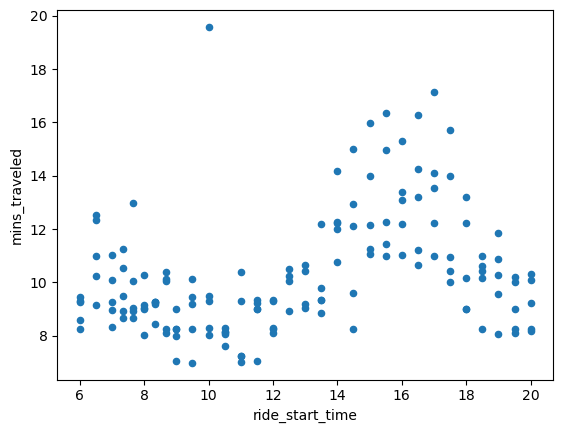

In [86]:
first_last.plot.scatter('ride_start_time', 'mins_traveled')

In [91]:
avgs = first_last.groupby('ride_start_time').mean().reset_index()

C:\Users\asher\AppData\Local\Temp\ipykernel_32204\2958982772.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avgs = first_last.groupby('ride_start_time').mean().reset_index()


<AxesSubplot: xlabel='ride_start_time'>

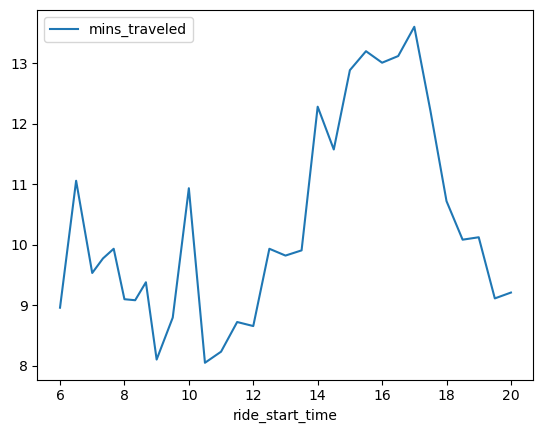

In [94]:
avgs.plot.line('ride_start_time', 'mins_traveled')

In [96]:
avgs.to_excel('before_ramp.xlsx')